In [1]:
## Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Dict, Any, Tuple
import pickle
import torch


In [2]:
## Functions

def get_sorted_most_likely_trajectories(logits: np.ndarray, lattice: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    
    softmax = torch.nn.Softmax(dim=1)
    probabilities = softmax(torch.Tensor(logits))
    sortedProbabilitiesIndices = np.flip(np.array(np.argsort(probabilities, axis=-1))).copy()
    sortedProbabilities = np.array(np.take_along_axis(probabilities, sortedProbabilitiesIndices, axis=-1))
    sortedTrajectories = lattice[sortedProbabilitiesIndices]
    
    return [sortedProbabilities, sortedTrajectories]


def get_ADE_for_k_trajectories(sorted_predicted_trajectories, ground_truth_trajectories, k_nr_of_trajectories) -> Tuple[np.array, np.array]:
    
    top_k_trajectories = sorted_predicted_trajectories[:,:k_nr_of_trajectories,:,:]
    
    n_epochs = 10 # TODO, automate
    n_datapoints_per_epoch = 512 # TODO, automate
    
    ave_ADE = np.zeros([n_datapoints_per_epoch, n_epochs])
    min_ADE = np.zeros([n_datapoints_per_epoch, n_epochs])
    count = 0
    # Loop over epochs
    for e in range(n_epochs):
        
        # Loop over datapoints
        for d in range(n_datapoints_per_epoch):
            tmp_ADE = 1e10
            min_ADE[d,e] = tmp_ADE
            # Loop over each trajectory
            for k in range(k_nr_of_trajectories):
                tmp_ADE = np.mean(np.linalg.norm(top_k_trajectories[count,k,:,:] - ground_truth_trajectories[count,:,:], axis=-1))
#                 print(f"tmp_ADE = {tmp_ADE}")
                ave_ADE[d,e] += tmp_ADE/k_nr_of_trajectories
                if tmp_ADE < min_ADE[d,e]:
                    min_ADE[d,e] = tmp_ADE
            count += 1
            
    return [np.mean(min_ADE, axis=0), np.mean(ave_ADE, axis=0)]


In [3]:
## Load data
# epochs = [50,51,52,53,54,55,56,57,300,301]
# legend_list = ['250*250','125*125','50*50','10*10','2*2','1*1','50*50 + covernet input','125*125 + covernet input','125*125 (300e)','10*10 (301e)']

epochs = [300,301]
legend_list = ['125*125 (300e)','10*10 (301e)']

file_path_list = [f"tmpResults/results_epochs={epoch}" for epoch in epochs]
num_files = len(file_path_list)
num_epochs = min(epochs)
test_ind = 0

# Load the .npy files
logits_loaded_list = [np.load(f'{file_path}_logits.npy') for file_path in file_path_list][:num_epochs]
ground_truth_loaded_list = [np.load(f'{file_path}_ground_truth.npy') for file_path in file_path_list][:num_epochs]


# Print the data
print(f"len(logits_loaded_list) = {len(logits_loaded_list)}")
print(f"len(ground_truth_loaded_list) = {len(ground_truth_loaded_list)}")
print(f"logits_loaded_list[{test_ind}].shape = {logits_loaded_list[test_ind].shape}")
print(f"ground_truth_loaded_list[{test_ind}].shape = {ground_truth_loaded_list[test_ind].shape}")


# Load lattice
with open('data/sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_8.pkl', 'rb') as f:
    trajectories = pickle.load(f)
lattice = np.array(trajectories)
                                

len(logits_loaded_list) = 2
len(ground_truth_loaded_list) = 2
logits_loaded_list[0].shape = (153600, 64)
ground_truth_loaded_list[0].shape = (153600, 12, 2)


In [4]:
## Calculate 

results = [get_sorted_most_likely_trajectories(logits_loaded, lattice) for logits_loaded in logits_loaded_list]
sorted_predicted_probabilities_list, sorted_predicted_trajectories_list = zip(*results)

print(f"len(sorted_predicted_probabilities_list) = {len(sorted_predicted_probabilities_list)}")
print(f"len(sorted_predicted_trajectories_list) = {len(sorted_predicted_trajectories_list)}")
print(f"sorted_predicted_probabilities_list[{test_ind}].shape = {sorted_predicted_probabilities_list[test_ind].shape}")
print(f"sorted_predicted_trajectories_list[{test_ind}].shape = {sorted_predicted_trajectories_list[test_ind].shape}")
# print(f"sortedTrajectories = {sorted_predicted_trajectories_list[0][2]}") # [0][0/1] and [0][2/3] the same

k_nr_of_trajectories = 5
results = [get_ADE_for_k_trajectories(sorted_predicted_trajectories, ground_truth_loaded, k_nr_of_trajectories) for sorted_predicted_trajectories, ground_truth_loaded in zip(sorted_predicted_trajectories_list, ground_truth_loaded_list)]
min_ADE_list, ave_ADE_list = zip(*results)

print(f"\nmin_ADE_list[{test_ind}] = {min_ADE_list[test_ind]}")
print(f"\nave_ADE_list[{test_ind}] = {ave_ADE_list[test_ind]}")

len(sorted_predicted_probabilities_list) = 2
len(sorted_predicted_trajectories_list) = 2
sorted_predicted_probabilities_list[0].shape = (153600, 64)
sorted_predicted_trajectories_list[0].shape = (153600, 64, 12, 2)

min_ADE_list[0] = [8.46673222 8.43139086 8.56577205 8.66289479 8.80200009 8.46002779
 8.40925124 8.51241209 8.46569427 8.6154547 ]

ave_ADE_list[0] = [15.38137249 15.53935406 15.59856585 15.86969679 15.98784682 15.54291785
 15.62976583 15.35777758 15.69194316 15.57728193]


In [5]:
## Plot ADE



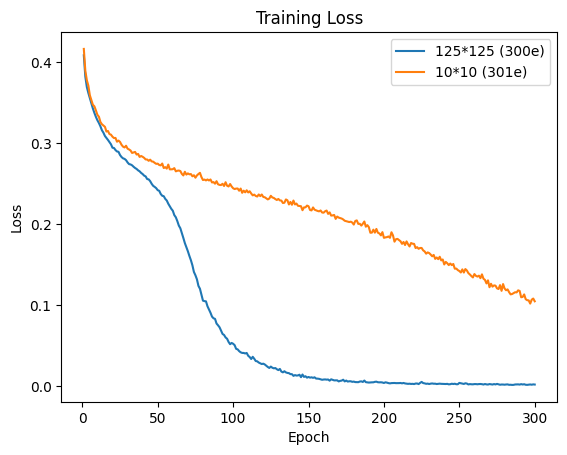

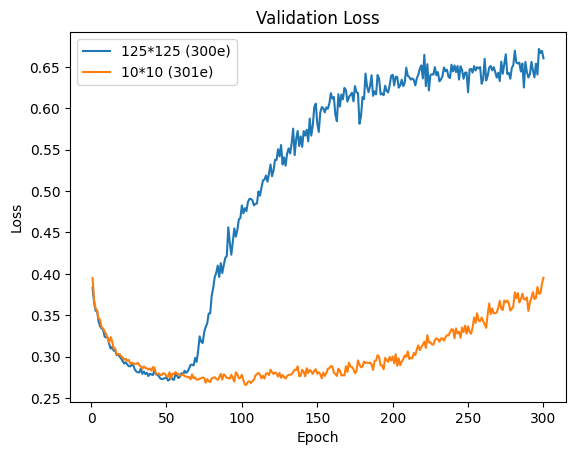

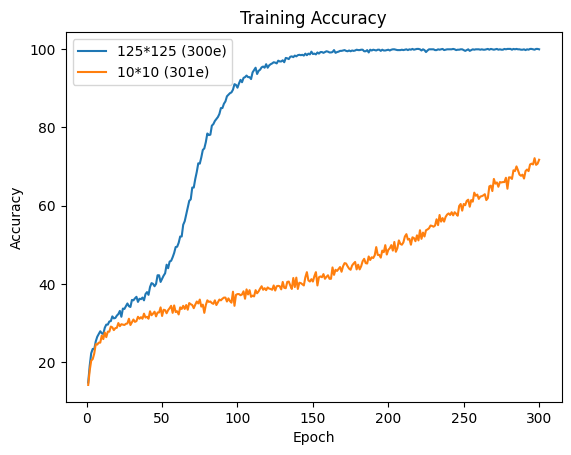

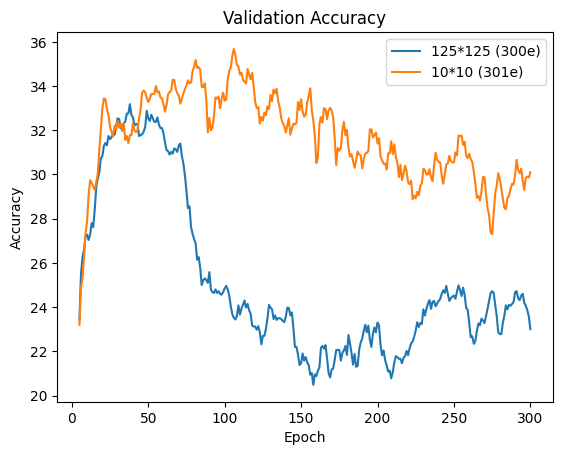

In [6]:
## Plot loss and accuracy

# File names
loss_acc_file_names = [f"{file_path}_loss_and_acc.txt" for file_path in file_path_list]

# Create empty arrays to store the data from text files
epochs = np.zeros((num_files, num_epochs))
train_loss = np.zeros((num_files, num_epochs))
val_loss = np.zeros((num_files, num_epochs))
train_acc = np.zeros((num_files, num_epochs))
val_acc = np.zeros((num_files, num_epochs))

# Loop over the text files
for i, filename in enumerate(loss_acc_file_names):
    with open(filename, 'r') as f:
        for j, line in enumerate(f):
            if j == num_epochs:
                break
            if line.startswith('Epoch'):
                parts = line.split(': ')
                epoch = int(parts[0].split('[')[1].split('/')[0])
                epochs[i][j] = epoch
                train_loss[i][j] = float(parts[2].split(' |')[0])
                val_loss[i][j] = float(parts[3].split(' |')[0])
                train_acc[i][j] = float(parts[4].split(' %')[0])
                val_acc[i][j] = float(parts[5].split(' %')[0])
if num_files > 4:
    val_loss[4,0] = val_loss[4,1]



# Training loss
plt.figure()
for i in range(num_files):
    plt.plot(epochs[i], train_loss[i], label=f'File {i+1}')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(legend_list)
plt.show()

# Validation loss
plt.figure()
for i in range(num_files):
    plt.plot(epochs[i], val_loss[i], label=f'File {i+1}')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(legend_list)
plt.show()

# Training accuracy
plt.figure()
for i in range(num_files):
    plt.plot(epochs[i], train_acc[i], label=f'File {i+1}')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(legend_list)
plt.show()

# Validation accuracy
plt.figure()
for i in range(num_files):
    # Convert the list to a pandas DataFrame
    df = pd.DataFrame(val_acc[i])
    # Apply a rolling window of size x and take the mean of each window
    smoothed = df.rolling(5).mean()
    # Convert the smoothed DataFrame back to a list
    smoothed_list = smoothed.values.tolist()
    numpy_smoothed_list = np.array(smoothed_list)
    squeezed_numpy_smoothed_list = np.squeeze(numpy_smoothed_list, 1)
    plt.plot(epochs[i], squeezed_numpy_smoothed_list, label=f'File {i+1}')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(legend_list)
plt.show()
